# Demonstration of issues with the Laplacian operator of Monaghan-Gingold (1983)

## Using this notebook

- You can just browse this notebook to see the description, code, and the results.

- You can also explicitly run the code by executing the cells which will take a few minutes of time.  If you do this, please first install PySPH before doing anything else.

- You can also modify the code and rerun anything you want.



## Problem definition
Show the accuracy of the modified Monaghan-Gingold
Laplacian operator [1] by computing the Laplacian
of the following function,

$$
    f(x, y) = \sin(2 \pi (x+y)),
$$

on a periodic domain with the points/particles placed on both
a uniform grid and a perturbed grid. For the perturbation case,
particles are given a small displacement drawn from a uniform
random distribution in each coordinate axis such that the
largest displacement is $k \Delta x$, $k$ being a constant
which we set as $0.01$. The exact solution of the Laplacian
is given by,

$$
    \frac{\partial^2 f}{\partial x^2}(x, y) + 
    \frac{\partial^2 f}{\partial y^2}(x, y) = 
    -8\pi^2\sin(2 \pi (x+y)).
$$

In the perturbed case, the exact value is sampled onto the
particles after displacement and then SPH approx is performed.
A smoothing length factor, $h/\Delta x = 1.2$, is used in this
simulation. The value of the Monaghan-Gingold viscous operator
at a particle $i$ is given by,

$$
    <\nabla \cdot \nabla f(x_i, y_i)>_{\text{SPH Approx}} =
    \sum_j \frac{4 m_j}{\rho_i + \rho_j}
    (f(x_j, y_j) - f(x_i, y_i)) 
    \frac{\nabla W(\mathbf{x}_{ij}, h_{ij})
    \cdot \mathbf{x}_{ij}}{|\mathbf{x}_{ij}|^2 + \epsilon}
$$

where the vector $\mathbf{x}_{ij} = [x_i - x_j, y_i - y_j]^T$ is
the difference between the position of the particles $i$ and
$j$, $W(\mathbf{x}_{ij}, h_{ij})$ is the kernel function, $m_j$
is the masss of the particle, $rho_i$ is the density of the
particle, and $\epsilon = 0.01 h_i$ is added to prevent divison
by zero. The summation is done over all the neighboring
particles of particle $i$.


[1] J. J. Monaghan and R. A. Gingold, J. Comput. Phys. 52, 374 (1983)

## Implementation

This section implements the problem in PySPH.  We first start with some preliminary imports and configuration for the plots.

In [6]:
# Numpy and matplotlib imports to define functions
# and make high quality plots.
import numpy as np
from numpy import cos, sin, pi
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib import rc, patches, colors

# PySPH is the SPH framework on top which we 
# implemented Adaptive SPH
from pysph.base.kernels import QuinticSpline
from pysph.base.nnps import DomainManager
from pysph.base.utils import get_particle_array 
from pysph.sph.equation import Equation, Group
from pysph.tools.sph_evaluator import SPHEvaluator

In [3]:
%matplotlib inline

# Configuration to generate quality plots
rc('legend', fontsize='medium')
rc('axes', grid=True, linewidth=1.5, titlesize='medium')
rc('axes.grid', which='both', axis='both')
rc('grid', linewidth=0.5, linestyle='--')
rc('xtick', direction='in', top=True)
rc('ytick', direction='in', right=True)
rc('lines', linewidth=2.0)

In [4]:
# Size of the square domain; 
sizex = 1
sizey = 1

### Defining the SPH operators we use

In [7]:
# Standard summation density equation. First, the `initialize` method
# is run over all the particles. Then, the `loop` method is run over
# all the neighboring particles of all the particles in the domain.

class SummationDensity(Equation):
    def initialize(self, d_idx, d_rho):
        d_rho[d_idx] = 0.0

    def loop(self, d_idx, s_idx, d_rho, s_m, WIJ):
        d_rho[d_idx] += s_m[s_idx]*WIJ


class LaplacianOperator(Equation):
    def __init__(self, dest, sources, nu):
        self.nu = nu
        super().__init__(dest, sources)

    def initialize(self, d_idx, d_d2f_dx2):
        d_d2f_dx2[d_idx] = 0.0

    def loop(self, d_idx, s_idx, d_rho, s_rho, s_m, d_d2f_dx2,
             R2IJ, EPS, DWIJ, d_f, s_f, XIJ):
        dw_dot_xij = DWIJ[0]*XIJ[0] + DWIJ[1]*XIJ[1] + DWIJ[2]*XIJ[2]

        Vj = s_m[s_idx] / (d_rho[d_idx] + s_rho[s_idx])

        tmp = Vj * 4 * self.nu * dw_dot_xij/(R2IJ + EPS)

        d_d2f_dx2[d_idx] += tmp * (d_f[d_idx] - s_f[s_idx])

### Code to create the domain and particles

In [8]:
def create_domain(lx, ly):
    return DomainManager(xmin=-lx, xmax=lx, ymin=-ly, ymax=ly,
                         periodic_in_x=True, periodic_in_y=True)


def create_particles(dx, perturb, hdx):
    dim = 2
    _x = np.arange(-sizex+dx/2, sizex, dx)
    _y = np.arange(-sizey+dx/2, sizey, dx)
    x, y = np.meshgrid(_x, _y)

    m = dx**dim
    h = hdx * dx

    if perturb > 0.0:
        np.random.seed(1234)
        
        # Randomly displace the particles by atmost perturb \times dx.
        x += np.random.random(x.shape) * perturb * dx
        y += np.random.random(y.shape) * perturb * dx

    fluid = get_particle_array(name='fluid', x=x, y=y, h=h, m=m, rho=1.0)

    props = ['f', 'f_approx', 'd2f_dx2', 'laplace_exact', 'f_exact']
    for prop in props:
        fluid.add_property(prop)
    fluid.add_property('m_mat', stride=9)
    fluid.add_property('gradf', stride=3)
    return fluid


def create_equations(fluid, kernel):
    eqns = []
    eqns.append(Group(
        equations=[SummationDensity(fluid.name, [fluid.name])],
        update_nnps=True
    ))
    eqns.append(Group(
        equations=[LaplacianOperator(fluid.name, [fluid.name], nu=1.0)]
    ))
    
    domain_manager = create_domain(lx=sizex, ly=sizey)
    sph_eval = SPHEvaluator(
        arrays=[fluid], equations=eqns, dim=2,
        kernel=kernel, domain_manager=domain_manager
    )
    return sph_eval

### Functions to compute SPH approximation and error

In [9]:
def compute_approximation(dx=0.05, perturb=0.0, hdx=1.2):
    kernel = QuinticSpline(dim=2)
    fluid = create_particles(dx, perturb, hdx)

    x, y = fluid.x, fluid.y
    f_exact = sin(2*pi*(x+y))

    d2fdx2_exact = -(2*pi)**2 * sin(2*pi * (x+y))
    d2fdy2_exact = -(2*pi)**2 * sin(2*pi * (x+y))
    laplace_exact = d2fdx2_exact + d2fdy2_exact

    fluid.f[:] = f_exact
    fluid.f_exact[:] = f_exact
    fluid.laplace_exact = laplace_exact

    sph_eval = create_equations(fluid, kernel)
    sph_eval.update()
    sph_eval.evaluate()

    # Compute average L_1 error.
    lap_err = np.sum(np.abs(fluid.d2f_dx2 - laplace_exact)) / len(fluid.x)
    return fluid, lap_err

Simple function to plot results.

In [10]:
def plot(fluid):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=100, sharey=True,
                           constrained_layout=True)
    ax[0].set_title("SPH laplacian approximation")
    img = ax[0].scatter(fluid.x, fluid.y, c=fluid.d2f_dx2, s=2, cmap='jet',
                        vmin=min(fluid.d2f_dx2), vmax=max(fluid.d2f_dx2))
    ax[0].set_xlabel(r"$x$")
    ax[0].set_ylabel(r"$y$")
    
    ax[1].set_title("Exact laplacian")
    img2 = ax[1].scatter(fluid.x, fluid.y, c=fluid.laplace_exact, s=2,
                         cmap='jet', vmin=min(fluid.d2f_dx2),
                         vmax=max(fluid.d2f_dx2))
    fig.colorbar(img2)
    ax[1].set_xlabel(r"$x$")
    ax[1].set_ylabel(r"$y$")
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=100,
                           constrained_layout=True)
    ax.set_title("Error in SPH approximation")
    img3 = ax.scatter(fluid.x, fluid.y,
                      c=np.abs(fluid.laplace_exact-fluid.d2f_dx2),
                      s=2, cmap='jet')
    fig.colorbar(img3, label=r'Average $L_1$ error')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

## Results

We first test a simple case with a $\Delta x=0.02$ and with a perturbation of 0.01 and plot the results to make sure it looks correct.


In [11]:
fluid, lap_err = compute_approximation(dx=0.02, perturb=0.01, hdx=1.2)

running build_ext
cythoning /root/.pysph/source/py3.7-linux-x86_64/m_5be3e8460cbc08949b42b7013dff18b1.pyx to /root/.pysph/source/py3.7-linux-x86_64/m_5be3e8460cbc08949b42b7013dff18b1.cpp


building 'm_5be3e8460cbc08949b42b7013dff18b1' extension
creating /root/.pysph/source/py3.7-linux-x86_64/build/temp.linux-x86_64-3.7
creating /root/.pysph/source/py3.7-linux-x86_64/build/temp.linux-x86_64-3.7/root
creating /root/.pysph/source/py3.7-linux-x86_64/build/temp.linux-x86_64-3.7/root/.pysph
creating /root/.pysph/source/py3.7-linux-x86_64/build/temp.linux-x86_64-3.7/root/.pysph/source
creating /root/.pysph/source/py3.7-linux-x86_64/build/temp.linux-x86_64-3.7/root/.pysph/source/py3.7-linux-x86_64
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/local/lib/python3.7/dist-packages/pysph/base 

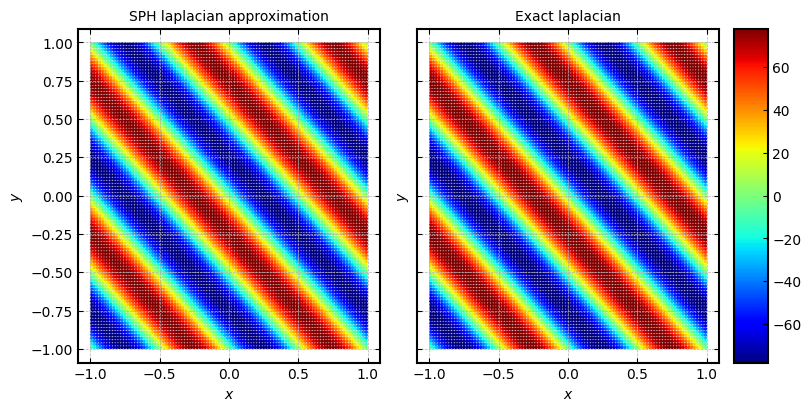

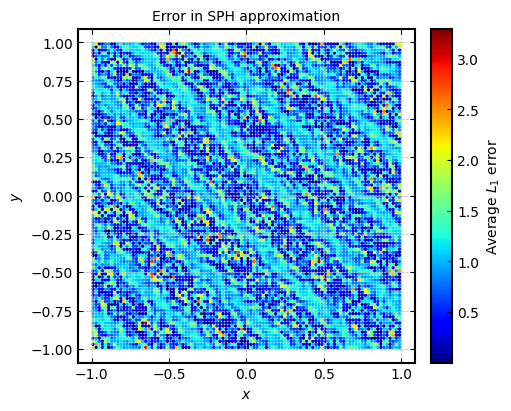

In [12]:
plot(fluid)

### Convergence computation

We now vary the resolution and study the convergence for the case without any perturbation.

In [ ]:
dxs = np.array([0.02, 0.01, 0.005, 0.0025])
hdx = 1.2
laplace_error = []
for dx in dxs:
    fluid, lap_err = compute_approximation(dx=dx, perturb=0.0, hdx=hdx)
    laplace_error.append(lap_err)
print(laplace_error)

[0.6855981975861767, 0.48146715102201926, 0.4302066275745704, 0.41737722499457525, 0.4141689817940061]


Now we do the same with a small perturbation.

In [ ]:
laplace_error_pert = []
for dx in dxs:
    perturb = 0.01
    fluid, lap_err = compute_approximation(dx=dx, perturb=perturb, hdx=hdx)
    laplace_error_pert.append(lap_err)
print(laplace_error_pert)

[0.8904724982563564, 1.1358905381177828, 2.0332255791350544, 3.9188493211488784, 7.7681687869468155]


Plotting the results.

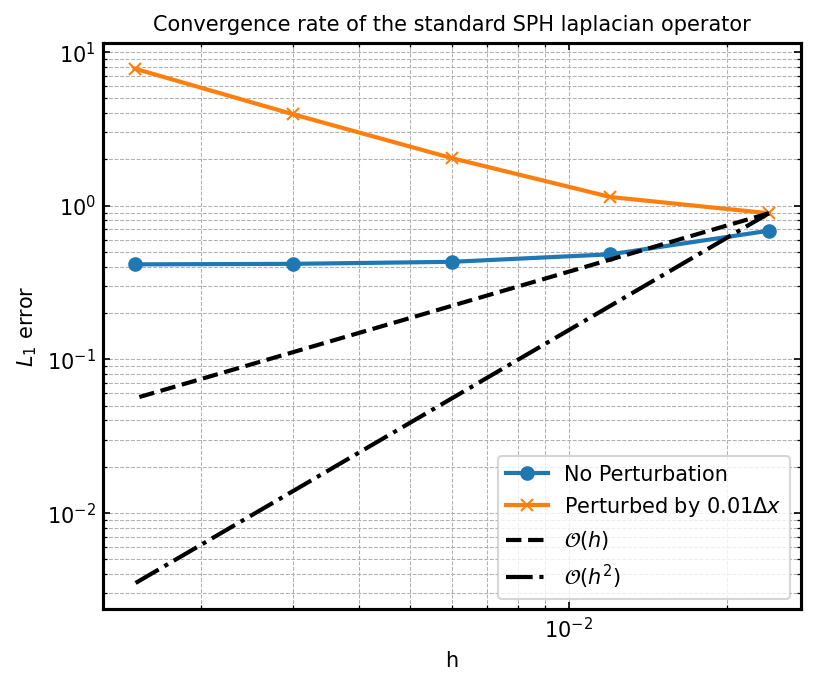

In [ ]:
h = 1.2 * dxs
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
ax.loglog(h, laplace_error, '-o', label='No Perturbation')
ax.loglog(h, laplace_error_pert, '-x',
          label=fr'Perturbed by {perturb}$\Delta x$')
ax.loglog(h,  laplace_error_pert[0] * (h/h[0])**1, '--k',
          label=r'$\mathcal{O}(h)$')
ax.loglog(h,  laplace_error_pert[0] * (h/h[0])**2, '-.k',
          label=r'$\mathcal{O}(h^2)$')
ax.set_title("Convergence rate of the standard SPH laplacian operator")
ax.set_xlabel('h')
ax.set_ylabel(r'$L_1$ error')
ax.legend();

As can be seen, the unperturbed results do not produce increasing errors
but the method is not even first order convergent. The instant
a perturbation is added the method actually diverges producing larger
errors. This test case is reproduced from the work of Negi et al. [2].,
where the authors compare the convergence of many SPH first and second
order derivative operators on both the uniform particle distribution and
a perturbed particle distribution. A similar conclusion was derived
from the theoretical work of Fatehi et al. [4], where the authors prove
the failure of convergence of standard SPH operators and proposes
a first-order consistent second derivative operator based on modified
renormalization tensor. In [4] the method of manufactured solutions (MMS) is
used to show the convergence of a weakly compressible SPH scheme.

[2] P. Negi and P. Ramachandran, "A new family of second order convergent
    weakly-compressible SPH schemes", arXiv:2107.11859 [physics], Aug. 2021,
    [Online]. Available: http://arxiv.org/abs/2107.11859

[3] R. Fatehi and M. T. Manzari, "Error estimation in smoothed particle hydrodynamics
    and a new scheme for second derivatives", Computers & Mathematics with
    Applications, vol. 61, no. 2, pp. 482-498, Jan. 2011,
    doi: 10.1016/j.camwa.2010.11.028.

[4] P. Negi and P. Ramachandran, "How to train your solver: A method of manufactured
    solutions for weakly compressible smoothed particle hydrodynamics",
    Physics of Fluids, vol. 33, no. 12, p. 127108, Dec. 2021, doi: 10.1063/5.0072383.